# Consommation et prix de l'électricité en France 

On travaille sur une base de données "Bilan Électrique au pas demi-heure" mise à disposition par **Enedis** sur le site data.gouv.fr. 
**Enedis** est le gestionnaire de réseaux de distribution de l'électricité en France. 

De plus, on a également souhaité récupérer les données de prix de l'électricité pour pouvoir mettre en évidence la relation entre la consommation et les prix. 
Pour cela, on a récupéré sur le site **Nord Pool** qui est la plus grande bourse du marché de l'énergie en Europe, les données de prix au pas horaire. 

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
sns.set_theme(style="darkgrid")

In [3]:
df_conso = pd.read_csv("C:\\Users\\seren\\OneDrive\\Bureau\\M2S1\\ALGO&PYTHON\\bilan-electrique-demi-heure.csv", sep = ";")

## Analyse de la base de données de consommation

Avant même de commencer la modélisation, nous allons procéder à une analyse de la base pour vérifier : 
    <li> La taille de la base 
    <li> Les valeurs manquantes 
    <li> Les types de variables 
    <li> Les valeurs aberrantes 

afin de s'assurer qu'elle soit exploitable. 

### Dimension de la base de données 

In [4]:
df_conso.shape

(87648, 24)

In [5]:
df_conso.columns

Index(['Horodate', 'Mois', 'Injection RTE (W)', 'Refoulement RTE (W)',
       'Pertes modélisées (W)', 'Consommations totale (W)',
       'Consommation totale télérelevée (W)',
       'Consommation totale profilée (W)', 'Consommation HTA profilée (W)',
       'Consommation PME-PMI profilée (W)',
       'Consommation professionnelle profilée (W)',
       'Consommation résidentielle profilée (W)',
       'Production décentralisée totale (W)',
       'Production décentralisée télérelevée à courbe de charge (W)',
       'Production décentralisée profilée (W)',
       'Production photovoltaïque profilée (W)',
       'Production autre profilée (W)', 'Température réalisée lissée (°C)',
       'Température normale lissée (°C)', 'Production éolienne totale (W)',
       'Production photovoltaïque totale (W)', 'Pseudo rayonnement',
       'Consommation HTA totale (W)', 'Soutirage net vers autres GRD (W)'],
      dtype='object')

La base de données comportant les données de consommation possède donc `87 648` observations pour `24` variables : 
    <li> `horodate`: La date au pas de demi-horaire
    <li> `Mois`
    <li> `Injection RTE (W)` : RTE est le gestionnaire de réseaux de transport de l'électricité en France. Cette variable quantifie donc la quantité d'électricité injecté sur le réseaux en Watt
    <li> `Refoulement RTE (W)` 
    <li> `Pertes modélisées (W)` : Cette variable représente la perte d'électricité subit sur le réseaux. Elles sont calculées par un polynôme de type A.P² + B.P + C, avec P la puissance et A,B,C des coefficients réévaluées chaque année. 
    <li> `Consommations totale, télérelevée et profilée (W)` : télérelevée signifie que la consommateur dispose d'un compteur qui calcule en temps réel la consommation, ceux qui ne disposent pas d'un tel compteur sont donc des profilés : leur consommation est estimée selon leur profil et celle-ci dépend alors de la température et de la conjoncture actuelle. 
    <li> `Consommation HTA` : représente les consommateurs dits à Haute Tension. 
    <li> `Consommation PME-PMI, professionelle` : consommations des professionnels, PME-PMI représentant les petites et moyennes entreprises. 
    <li> `Consommation résidentielle` représente donc celle des particuliers 
    <li> `Production décentralisée` représente la production d'électricité d'installation de petite capacité.
            

In [6]:
df_conso.head(10)

,Horodate,Mois,Injection RTE (W),Refoulement RTE (W),Pertes modélisées (W),Consommations totale (W),Consommation totale télérelevée (W),Consommation totale profilée (W),Consommation HTA profilée (W),Consommation PME-PMI profilée (W),...,Production décentralisée profilée (W),Production photovoltaïque profilée (W),Production autre profilée (W),Température réalisée lissée (°C),Température normale lissée (°C),Production éolienne totale (W),Production photovoltaïque totale (W),Pseudo rayonnement,Consommation HTA totale (W),Soutirage net vers autres GRD (W)
0,2020-10-20T09:30:00+02:00,10,4.289583e+10,4.076520e+09,2.998834e+09,4.493303e+10,1.464271e+10,3.029032e+10,1.865798e+09,7.575023e+09,...,239647744.0,224980221.0,3660903.0,11.2,12.2,7.695118e+09,5.149727e+08,11.0,1.650851e+10,330019373.0
1,2020-10-20T12:00:00+02:00,10,4.333602e+10,4.265215e+09,3.125184e+09,4.627304e+10,1.419591e+10,3.207713e+10,1.706854e+09,6.773464e+09,...,730574337.0,716023537.0,3660903.0,12.4,13.1,7.687336e+09,1.716482e+09,7.0,1.590277e+10,317024982.0
2,2020-10-20T17:30:00+02:00,10,3.805279e+10,4.231954e+09,2.631003e+09,4.010122e+10,1.286971e+10,2.723151e+10,1.561773e+09,5.973193e+09,...,157270318.0,142345156.0,3660903.0,13.5,14.2,7.652356e+09,3.085066e+08,3.0,1.443149e+10,275383290.0
3,2020-10-21T01:00:00+02:00,10,3.303353e+10,3.963927e+09,2.239883e+09,3.465815e+10,1.022670e+10,2.443145e+10,1.140185e+09,3.539265e+09,...,13418778.0,55140.0,3568844.0,12.8,12.4,6.942612e+09,8.307730e+05,4.0,1.136689e+10,256012359.0
4,2020-10-21T01:30:00+02:00,10,3.252284e+10,4.173912e+09,2.222280e+09,3.418453e+10,1.019306e+10,2.399147e+10,1.131348e+09,3.483127e+09,...,13391071.0,91577.0,3568844.0,12.8,12.4,7.144654e+09,8.689600e+05,4.0,1.132441e+10,239817132.0
5,2020-10-21T05:00:00+02:00,10,2.931708e+10,5.797709e+09,2.134175e+09,3.115923e+10,1.110349e+10,2.005574e+10,1.226815e+09,3.896682e+09,...,14116412.0,412731.0,3568844.0,13.0,12.2,8.825359e+09,1.092721e+06,7.0,1.233031e+10,206360523.0
6,2020-10-21T07:00:00+02:00,10,3.614609e+10,6.173304e+09,2.624611e+09,3.808835e+10,1.315405e+10,2.493430e+10,1.475289e+09,5.098130e+09,...,14371819.0,530908.0,3568844.0,13.1,12.1,9.840504e+09,1.108751e+06,16.0,1.462934e+10,258803144.0
7,2020-10-22T02:00:00+02:00,10,3.111616e+10,2.719912e+09,2.021127e+09,3.225943e+10,1.012420e+10,2.213522e+10,1.118943e+09,3.394161e+09,...,13806154.0,111779.0,3571256.0,14.7,12.3,4.969183e+09,8.967660e+05,44.0,1.124315e+10,249854636.0
8,2020-10-22T03:30:00+02:00,10,2.790259e+10,2.968069e+09,1.861040e+09,2.907555e+10,1.018231e+10,1.889324e+10,1.123807e+09,3.445802e+09,...,13782404.0,214977.0,3571256.0,14.7,12.2,5.064745e+09,9.976400e+05,40.0,1.130611e+10,232952905.0
9,2020-10-22T08:00:00+02:00,10,3.914407e+10,2.147328e+09,2.449889e+09,3.959963e+10,1.400596e+10,2.559367e+10,1.661775e+09,6.183132e+09,...,15746739.0,1318281.0,3571256.0,14.4,11.8,4.217338e+09,4.296366e+06,28.0,1.566774e+10,313964027.0


On se rend compte ici que les données de date ne sont pas ordonnées.

In [7]:
df_conso = df_conso.sort_values(by=['Horodate'])

### Valeurs manquantes et types de variables

In [8]:
Nom_Var = df_conso.columns
def var(nomvar,data):
    print("Nom de la var : " + nomvar)
    print(f"Nombre de modalités : {data[nomvar].nunique()}")
    print(f"Vecteurs des modalités : {data[nomvar].unique()}")
    print(f"Counts en chaque modalités : {data[nomvar].value_counts()}")
    print(data[nomvar].describe())
    print(f"La colonne a {data[nomvar].isna().sum()}  valeur(s) manquante(s)")
    print(f"La variable admet donc {(data[nomvar].isna().sum()/len(data))*100} % de valeur(s) manquante(s)")
    
def num_missing(x):
    return sum(x.isnull())

In [9]:
for i in Nom_Var : 
    print(var(i,df_conso))

Nom de la var : Horodate
Nombre de modalités : 87648
Vecteurs des modalités : ['2016-10-23T00:00:00+02:00' '2016-10-23T00:30:00+02:00'
 '2016-10-23T01:00:00+02:00' ... '2021-10-22T22:30:00+02:00'
 '2021-10-22T23:00:00+02:00' '2021-10-22T23:30:00+02:00']
Counts en chaque modalités : 2019-04-27T09:30:00+02:00    1
2019-11-13T10:00:00+01:00    1
2017-12-07T20:30:00+01:00    1
2018-06-21T01:30:00+02:00    1
2021-05-22T16:30:00+02:00    1
                            ..
2020-03-27T20:00:00+01:00    1
2019-03-24T15:00:00+01:00    1
2020-02-13T12:30:00+01:00    1
2018-09-25T16:00:00+02:00    1
2017-10-14T18:30:00+02:00    1
Name: Horodate, Length: 87648, dtype: int64
count                         87648
unique                        87648
top       2019-04-27T09:30:00+02:00
freq                              1
Name: Horodate, dtype: object
La colonne a 0  valeur(s) manquante(s)
La variable admet donc 0.0 % de valeur(s) manquante(s)
None
Nom de la var : Mois
Nombre de modalités : 12
Vecteurs des 

In [10]:
print("Valeurs manquantes par colonne:")
print(df_conso.apply(num_missing, axis=0)) 

Valeurs manquantes par colonne:
Horodate                                                          0
Mois                                                              0
Injection RTE (W)                                                 0
Refoulement RTE (W)                                               0
Pertes modélisées (W)                                             0
Consommations totale (W)                                          0
Consommation totale télérelevée (W)                               0
Consommation totale profilée (W)                                  0
Consommation HTA profilée (W)                                     0
Consommation PME-PMI profilée (W)                                 0
Consommation professionnelle profilée (W)                         0
Consommation résidentielle profilée (W)                           0
Production décentralisée totale (W)                               0
Production décentralisée télérelevée à courbe de charge (W)       0
Production décen

On voit donc que seule la variable `Pseudo rayonnement` admet des valeurs manquantes pour un total de 8%. 
En raison du nombre de valeurs manquantes et du fait que seule cette variable en admette, on décide de la supprimer.
On aurait pu essayer de modéliser cette variable pour voir si elle admettait une saisonnalité pour pouvoir estimer les valeurs manquantes. Cependant, le calcul de cette variable est trop complexe pour ce genre de modélisation. 

On observe également que toutes nos variables sont numériques. C'est également le cas de la variable de date, on décide donc de la mettre au format date 

In [11]:
df_conso.drop(columns = ["Pseudo rayonnement"], inplace = True)
df_conso["Horodate"] = pd.to_datetime(df_conso["Horodate"])


### Valeurs aberrantes 

La source de la base de données étant fiable, cela devrait être également le cas des mesures. 
Nous préférons tout de même vérifier s'il n'existe pas de valeurs aberrantes qui pourraient donc fausser la modélisation. 
Nous allons vérifier cela pour nos variables d'intérêts : La consommation et la température. 

C:\Users\seren\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


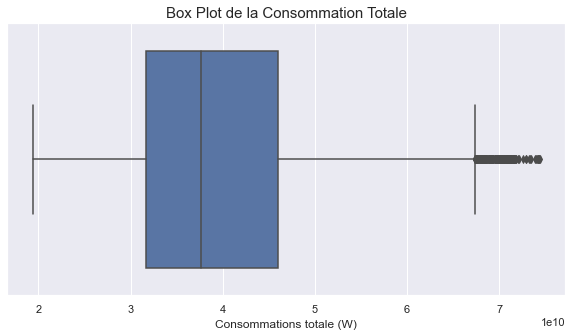

In [12]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(df_conso["Consommations totale (W)"])
plt.title('Box Plot de la Consommation Totale', fontsize=15);

C:\Users\seren\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


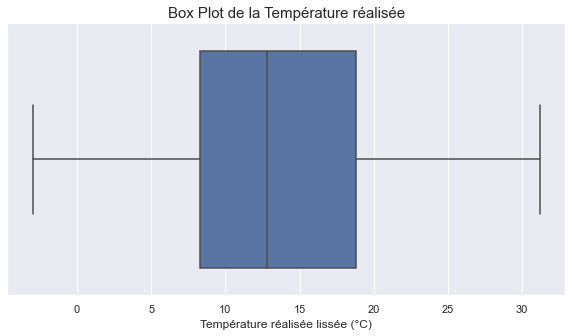

In [13]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(df_conso["Température réalisée lissée (°C)"])
plt.title('Box Plot de la Température réalisée', fontsize=15);

## Analyse de la base de données des prix 

La base de données qu'on avait à notre disposition jusque là était complète, mais il manquait une variable importante pour notre analyse : **le prix de l'électricité**. 
On a donc récupéré une autre base avec les prix au pas horaire. 
Sur le site de la bourse du marché de l'énergie, on a pu récupérer un fichier excel par année. 
On a donc dû les importer et les concaténer. 

In [14]:
# Importation et concaténation des prix 

dossiers = { 'data' : [2016,2022]}

dfs = []
k = 'data'
for i in range(dossiers[k][0],dossiers[k][1]):
    try:
        dfs.append(pd.read_excel(r'C:\\Users\\seren\\OneDrive\\Bureau\\M2S1\\ALGO&PYTHON\\{}\\{}.xlsx'.format(k,i)))
    except:
        pass
ganisland = pd.concat(dfs)
df_price = ganisland.reset_index()

df_price.drop(columns = ["index"], inplace = True)

In [15]:
df_price.shape

(51366, 3)

In [16]:
df_price.head(10)

,Date,Hours,Prix
0,2016-01-01,00:00:00,16.39
1,2016-01-01,01:00:00,16.04
2,2016-01-01,02:00:00,15.74
3,2016-01-01,03:00:00,15.57
4,2016-01-01,04:00:00,15.47
5,2016-01-01,05:00:00,15.75
6,2016-01-01,06:00:00,15.36
7,2016-01-01,07:00:00,15.37
8,2016-01-01,08:00:00,15.19
9,2016-01-01,09:00:00,15.39


Le dataframe contient donc `51 366` observations et `3` variables. 
Cependant, on ne peut pas concaténer directement ce dataframe avec celui des consommations car d'une part celui-ci est au pas horaire et non demi-horaire, et d'autre part la période de temps n'est pas la même. 
On décide donc de travailler au pas horaire. 

In [20]:
# On garde seulement les heures entières de la base de consommation
minutes = df_conso[df_conso['Horodate'].astype(str).str.contains(':30:')].index
df_conso.drop(minutes,0, inplace=True)

# On récupère la période qui nous intéresse 
df_price = df_price[(df_price["Date"] >= "2016-10-23") & (df_price["Date"] <= "2021-10-22" )]

In [21]:
print("Valeurs manquantes par colonne:")
print(df_price.apply(num_missing, axis=0)) 

Valeurs manquantes par colonne:
Date     0
Hours    0
Prix     5
dtype: int64


In [22]:
#Pour trouver les lignes qu'il y a en trop.
#On regarde quelle heure apparait plus que les autre
#On trouve qu'il y a 1831 minuit alors que pour les autres valeurs il n'y en a que 1826
df_price[df_price['Hours'].astype(str).str.contains('00:00:00')].count
df_conso[df_conso['Horodate'].astype(str).str.contains('T00:00:00')].count

<bound method DataFrame.count of Empty DataFrame
Columns: [Horodate, Mois, Injection RTE (W), Refoulement RTE (W), Pertes modélisées (W), Consommations totale (W), Consommation totale télérelevée (W), Consommation totale profilée (W), Consommation HTA profilée (W), Consommation PME-PMI profilée (W), Consommation professionnelle profilée (W), Consommation résidentielle profilée (W), Production décentralisée totale (W), Production décentralisée télérelevée à courbe de charge (W), Production décentralisée profilée (W), Production photovoltaïque profilée (W), Production autre profilée (W), Température réalisée lissée (°C), Température normale lissée (°C), Production éolienne totale (W), Production photovoltaïque totale (W), Consommation HTA totale (W), Soutirage net vers autres GRD (W)]
Index: []

[0 rows x 23 columns]>

On se rend compte que même au même pas de temps, et avec la même période, il y a 5 observations en trop dans le dataframe des prix. 
En faisant des analyses sur les valeurs manquantes, on se rend compte que la variable Prix admet exactement 5 valeurs manquantes. En cherchant plus loin on voit que cela correspondait à des occurences de l'heure 00h. On décide donc de supprimer ces lignes pour ensuite pouvoir concaténer les deux dataframes. 

In [23]:
#Pour supprimer les lignes en trop avec un nan dans la colonne prix
index_with_nan = df_price.index[df_price["Prix"].isnull()]
df_price.drop(index_with_nan,0, inplace=True)

#Suppression colonnes dans df5 pour qu'il ne reste que les prix
df_price = df_price.drop(['Hours', 'Date'], 1) 


#Remettre l'index à 0
df_conso = df_conso.reset_index(drop=False, inplace=False)
df_price = df_price.reset_index(drop=False, inplace=False)


#On concatène les deux fichiers
df_final = df_conso.merge(df_price, how='inner', left_index=True, right_index=True)

In [25]:
df_final.head()

df_final.drop(columns = ["index_x","index_y"], inplace = True)

C:\Users\seren\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


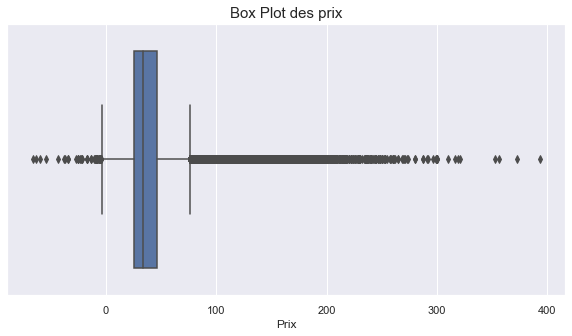

In [26]:
fig = plt.figure(figsize=(10,5))
sns.boxplot(df_final["Prix"])
plt.title('Box Plot des prix', fontsize=15);

# Analyse de la série chronologiques : quelques graphiques 

Nous allons dans cette partie tenter de visualiser graphiquement la série, afin de dégager les différentes composantes :
    <li> Une tendance 
    <li> Une saisonnalité 
    <li> Un bruit 
        
Par intuition, on suppose que la série admet au moins deux types de saisonnalité :
     <li> Une saisonnalité **mensuelle** : en effet, la consommation d'électricité fluctue en fonction du mois de l'année. On suppose qu'elle est plus elevée en hiver par rapport à l'été. 
     <li> Une saisonnalité **journalière** : en fonction du moment de la journée, la consommation électrique n'est pas la même.
        
En revanche, il convient de distinguer la consommation des professionnels et celle des particuliers. En effet, on s'attend à ce que la première soit plus importante en journée (durant les heures de travail), tandis que celle des particuliers doit atteindre un pic le matin ainsi qu'en soirée, et être plutôt faible la journée. 
        

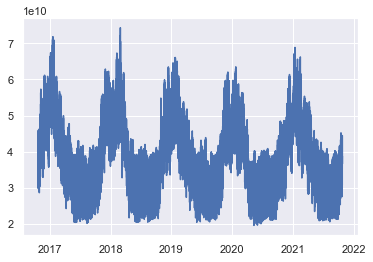

In [27]:
# Evolution de la consommation en fonction du temps
plt.plot(df_conso["Horodate"], df_conso["Consommations totale (W)"]) ; 

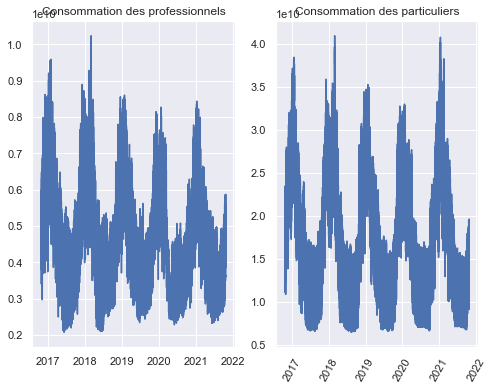

In [41]:
fig, [ax1, ax2]= plt.subplots(1, 2, figsize=(8, 6))

ax1.set_title("Consommation des professionnels")
ax1.plot(df_final["Horodate"], df_final["Consommation professionnelle profilée (W)"])
plt.xticks(rotation = 60)

ax2.set_title("Consommation des particuliers")
ax2.plot(df_final["Horodate"], df_final["Consommation résidentielle profilée (W)"]) 
plt.xticks(rotation = 60);

Conformément à notre intuition, on voit donc une saisonnalité mensuelle se dégager du graphique.
On suppose que les pics de consommation sont atteints en hiver, tandis que les moments où la consommation est minimale correspondent à des mois chauds. 

Pour confirmer cette intuition, nous allons zoomer ce même graphique sur une année seulement.

In [28]:
# On créé une nouvelle variable Year 
df_conso.insert(1, 'Year',df_conso["Horodate"].astype(str).str[:4] )
# On créé une nouvelle variable Hours 
df_conso.insert(2, 'Hours',df_conso["Horodate"].astype(str).str[11:13] )


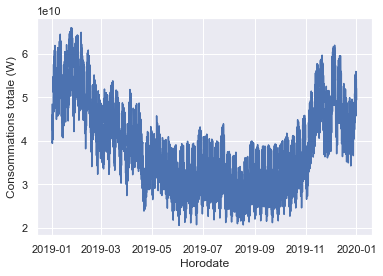

In [30]:
df_2019 = df_conso[df_conso["Year"] == "2019"]
sns.lineplot(x = "Horodate", y = "Consommations totale (W)",
             data = df_2019) ;

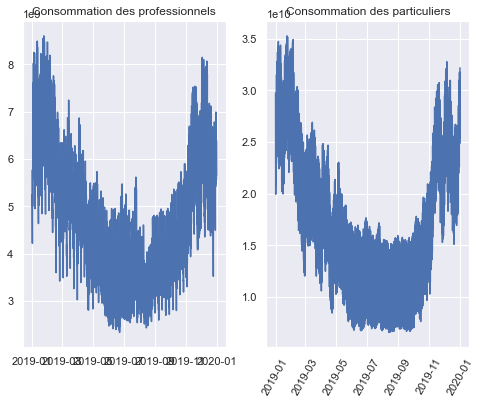

In [40]:
fig, [ax1, ax2]= plt.subplots(1, 2, figsize=(8, 6))

ax1.set_title("Consommation des professionnels")
ax1.plot(df_2019["Horodate"], df_2019["Consommation professionnelle profilée (W)"])
plt.xticks(rotation = 60)

ax2.set_title("Consommation des particuliers")
ax2.plot(df_2019["Horodate"], df_2019["Consommation résidentielle profilée (W)"]) 
plt.xticks(rotation = 60);

On a choisit de répresenter le graphique sur l'année `2019`.
Conformément à notre intuition, on voit que la consommation est plus elevée en hiver : elle est maximale au moins de janvier, puis baisse jusqu'a augmenter vers le mois de septembre.
On remarque également des oscillations au sein même des mois. On décide alors d'affiner encore plus notre graphique pour mettre en évidence les variations de consommation au sein d'une même journée et ainsi dégager la seconde saisonnalité journalière. 

A noter également qu'on observe une différence entre la consommation des professionnels et celle des particuliers : la première semble connaitre plus d'oscillations au sein de la journée contrairement à la seconde. 

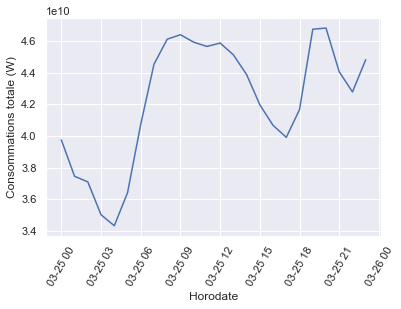

In [36]:
df_day = df_conso[df_conso["Horodate"].astype(str).str.startswith("2019-03-25")]
sns.lineplot(x = "Horodate", y = "Consommations totale (W)",
             data = df_day
             )
plt.xticks(rotation = 60);

On voit qu'un pic de consommation a lieu en milieu de journée, puis un second en début de soirée. 
Cela est conforme également à ce qu'on peut attendre : la nuit la consommation est presque nulle, puis elle augmente le matin et en fin de journée. 
De plus, la base regroupe les consommations de professionnelles et également de particuliers : les premiers consomment donc la journée pour leur activité, et les dernier consomment plutôt en fin de journée/début de soirée. 
On peut aisément vérifier cela séparant les deux consommations. 
On voit donc l'intéret ici de distinguer les deux consommations, puisque les comportements sont à l'opposé : le pic de consommation des professionels est atteint en journée, tandis que celle des particuliers en fin de journée/début de soirée. 

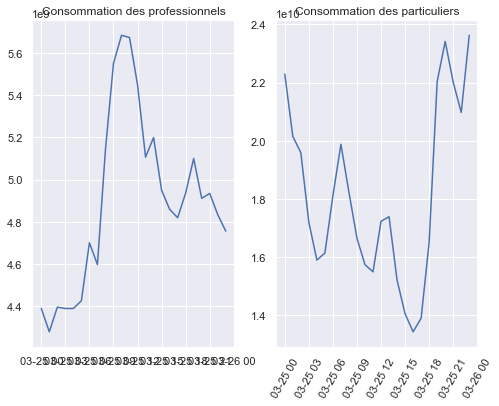

In [42]:
fig, [ax1, ax2]= plt.subplots(1, 2, figsize=(8, 6))

ax1.set_title("Consommation des professionnels")
ax1.plot(df_day["Horodate"], df_day["Consommation professionnelle profilée (W)"])
plt.xticks(rotation = 60)

ax2.set_title("Consommation des particuliers")
ax2.plot(df_day["Horodate"], df_day["Consommation résidentielle profilée (W)"]) 
plt.xticks(rotation = 60);
 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


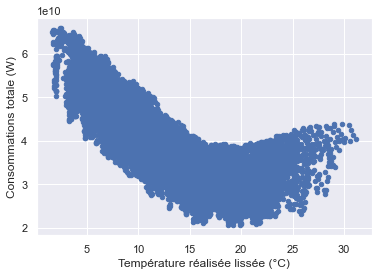

In [43]:
df_2019.plot(kind='scatter',
       x="Température réalisée lissée (°C)",
       y="Consommations totale (W)"); 

Notre intuition avant la construction du graphique était qu'il existe sûrement une corrélation négative entre la consommation d'énergie et la température avant un certain seuil : plus la température est basse et plus la consommation d'équipements électriques augmente, puis la consommation électrique diminue quand les températures remontent, jusqu'à une certaine température qui entraine une consommation accrue d'autres équipements (`Exemple` : les climatisations). 
Cette intuition est vérifiée par le graphique, et la température seuil semble être au alentour de 25 degrés. 

**Matrice de corrélation**

In [ ]:
sns.heatmap(df_final.corr().iloc[:8,:8],
           cmap = 'Reds',
           annot = True,  # met les corrélations dans les carrés
           fmt = '.1f')   # 1 chiffre après la virgule. Pour des entiers utiliser le format "d"
;

In [ ]:
sns.heatmap(df_final.corr().iloc[:8,8:16],
           cmap = 'Reds',
           annot = True,  
           fmt = '.1f')   
;

In [ ]:
sns.heatmap(df_final.corr().iloc[:8,16:24],
           cmap = 'Reds',
           annot = True,  
           fmt = '.1f')   
;

In [ ]:
sns.heatmap(df_final.corr().iloc[8:16,:8],
           cmap = 'Reds',
           annot = True,  
           fmt = '.1f')   
;

In [ ]:
sns.heatmap(df_final.corr().iloc[8:16,8:16],
           cmap = 'Reds',
           annot = True,  
           fmt = '.1f')   
;

In [ ]:
sns.heatmap(df_final.corr().iloc[8:16,16:24],
           cmap = 'Reds',
           annot = True,  
           fmt = '.1f')   
;

## Modélisation de la série temporelle 

On essaye de modéliser la série en dégageant la `tendance`, la `saisonnalité` et le `bruit`

In [ ]:
# On met la date en index
df_final.set_index("Horodate", inplace=True)

In [ ]:
list_col = ["Consommation résidentielle profilée (W)",
                 "Production décentralisée totale (W)", "Température réalisée lissée (°C)",
                 "Prix", "Year"]

df = df_final[list_col]


ax = df[df["Year"] == "2019"].plot(figsize=(15,4))
ax.legend(bbox_to_anchor=(1.4, 0.2));

In [ ]:
df_final["Consommations totale (W)"].dtype

In [ ]:
from statsmodels.tsa.tsatools import detrend

notrend = detrend(df['Consommations totale (W)'])
df_trend["notrend"] = notrend
df_trend["trend"] = df_trend['Consommations totale (W)'] - notrend
df_trend.tail()

In [ ]:
df_trend.head()